In [1]:
import pm4py
pm4py.__version__

'1.3.3'

In [27]:
import os
import numpy as np
import pandas as pd
import math

PROJ_ROOT = os.path.abspath(os.path.pardir)
data_dir = os.path.join(PROJ_ROOT, 'data')

assert os.path.exists(data_path)

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

# Q1.A

In [3]:
%%time
log = xes_importer.apply(os.path.join(data_dir, 'FMP.xes'))


CPU times: user 31.9 s, sys: 1.53 s, total: 33.5 s
Wall time: 39.8 s


In [4]:
df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

df.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+02:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+01:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+02:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+01:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+01:00,NaN,NaN,A100,NaN,P,P,NaN,NaN


In [6]:
df['concept:name'].value_counts()

Create Fine                              150370
Send Fine                                103987
Insert Fine Notification                  79860
Add penalty                               79860
Payment                                   77601
Send for Credit Collection                59013
Insert Date Appeal to Prefecture           4188
Send Appeal to Prefecture                  4141
Receive Result Appeal from Prefecture       999
Notify Result Appeal to Offender            896
Appeal to Judge                             555
Name: concept:name, dtype: int64

In [20]:
traces = df.groupby('case:concept:name')['concept:name'].apply(np.asarray)
has_appeal = traces.apply(lambda x: 'Appeal to Judge' in x or 'Send Appeal to Prefecture' in x)
has_appeal.name = 'has_appeal'
traces = df.groupby('case:concept:name')['concept:name'].apply(np.asarray)
df = df.join(has_appeal,on='case:concept:name')

df.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,has_appeal
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+02:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,False
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+01:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN,False
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+02:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,False
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+01:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN,False
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+01:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,False


In [22]:
df_appeal = df[df['has_appeal']==True]
df_no_appeal = df[df['has_appeal']==False]

In [25]:
log_appeal = log_converter.apply(df_appeal.drop(labels='has_appeal', axis=1), variant=log_converter.Variants.TO_EVENT_LOG)
log_no_appeal = log_converter.apply(df_no_appeal.drop(labels='has_appeal', axis=1), variant=log_converter.Variants.TO_EVENT_LOG)

In [26]:
for trace in log_appeal:
    for event in trace:

        todel = []
        for a in event:

            if type(event[a]) == float:
                if math.isnan(event[a]):
                    #print(a)
                    todel.append(a)

        for a in todel:
            #print(a)
            del event[a]
            

for trace in log_no_appeal:
    for event in trace:

        todel = []
        for a in event:

            if type(event[a]) == float:
                if math.isnan(event[a]):
                    #print(a)
                    todel.append(a)

        for a in todel:
            #print(a)
            del event[a]


In [28]:
xes_exporter.apply(log_appeal, os.path.join(data_dir, 'FMP_appeal.xes'))
xes_exporter.apply(log_no_appeal, os.path.join(data_dir, 'FMP_no_appeal.xes'))

# Q1.B

In [14]:
# all events in the original log
events = set([])
for trace in log:
    for e in trace:
        events.add(e['concept:name'])
events

{'Add penalty',
 'Appeal to Judge',
 'Create Fine',
 'Insert Date Appeal to Prefecture',
 'Insert Fine Notification',
 'Notify Result Appeal to Offender',
 'Payment',
 'Receive Result Appeal from Prefecture',
 'Send Appeal to Prefecture',
 'Send Fine',
 'Send for Credit Collection'}

In [15]:
def count_unique_traces(traces):
    
    distinct_traces = []
    for t in traces:
    
        found = False
        for distinct in distinct_traces:
            if np.array_equal(t, distinct):
                found = True
                break

        if not found:
            distinct_traces.append(t)
    
    return len(distinct_traces)

In [16]:
print(len(log))
print(count_unique_traces(traces))

print(len(log_appeal))
print(count_unique_traces(traces[has_appeal]))

print(len(log_no_appeal))
print(count_unique_traces(traces[has_appeal==False]))

150370
231
4513
170
145857
61


In [17]:
print(len(df))
print(traces.apply(len).mean())

print(len(df_appeal))
print(traces[has_appeal].apply(len).mean())

print(len(df_no_appeal))
print(traces[has_appeal==False].apply(len).mean())


561470
3.7339229899581032
29724
6.586306226456903
531746
3.645666646098576


In [18]:
print(df['time:timestamp'].min())
print(df['time:timestamp'].max())

print(df_appeal['time:timestamp'].min())
print(df_appeal['time:timestamp'].max())

print(df_no_appeal['time:timestamp'].min())
print(df_no_appeal['time:timestamp'].max())

2000-01-01 00:00:00+01:00
2013-06-18 00:00:00+02:00
2000-01-03 00:00:00+01:00
2013-06-14 00:00:00+02:00
2000-01-01 00:00:00+01:00
2013-06-18 00:00:00+02:00


In [19]:
print(df['lifecycle:transition'].unique())
print(df['lifecycle:transition'].count())
print('Since all lifecycle events are colete events the number of events and activities are equal')

['complete']
561470
Since all lifecycle events are colete events the number of events and activities are equal


In [20]:
set_length = traces.apply(set).apply(len)
set_length.name = 'set_length'
trace_length = traces.apply(len)
trace_length.name = 'trace_length'

df = df.join(set_length,on='case:concept:name')
df = df.join(trace_length,on='case:concept:name')

df_appeal = df[df['has_appeal']==True]
df_no_appeal = df[df['has_appeal']==False]

In [21]:
print(len(df[df['set_length'] != df['trace_length']]) / len(df))

print(len(df_appeal[df_appeal['set_length'] != df_appeal['trace_length']]) / len(df_appeal))

print(len(df_no_appeal[df_no_appeal['set_length'] != df_no_appeal['trace_length']]) / len(df_no_appeal))

0.08120825689707376
0.025232135647961243
0.08433725876640351


# Q1.C

In [22]:
print('absolute frequencies')
print(df.groupby('concept:name')['case:concept:name'].count())
print('relative frequencies')
print(df.groupby('concept:name')['case:concept:name'].count()/len(df))

absolute frequencies
concept:name
Add penalty                               79860
Appeal to Judge                             555
Create Fine                              150370
Insert Date Appeal to Prefecture           4188
Insert Fine Notification                  79860
Notify Result Appeal to Offender            896
Payment                                   77601
Receive Result Appeal from Prefecture       999
Send Appeal to Prefecture                  4141
Send Fine                                103987
Send for Credit Collection                59013
Name: case:concept:name, dtype: int64
relative frequencies
concept:name
Add penalty                              0.142234
Appeal to Judge                          0.000988
Create Fine                              0.267815
Insert Date Appeal to Prefecture         0.007459
Insert Fine Notification                 0.142234
Notify Result Appeal to Offender         0.001596
Payment                                  0.138210
Receive Result A

In [37]:
print('absolute trace frequencies')
print(df.groupby('concept:name')['case:concept:name'].nunique())
print('relative frequencies')
print(df.groupby('concept:name')['case:concept:name'].nunique()/df['case:concept:name'].nunique())

absolute frequencies
concept:name
Add penalty                               79860
Appeal to Judge                             555
Create Fine                              150370
Insert Date Appeal to Prefecture           4188
Insert Fine Notification                  79860
Notify Result Appeal to Offender            896
Payment                                   69715
Receive Result Appeal from Prefecture       999
Send Appeal to Prefecture                  4141
Send Fine                                103987
Send for Credit Collection                59013
Name: case:concept:name, dtype: int64
relative frequencies
concept:name
Add penalty                              0.531090
Appeal to Judge                          0.003691
Create Fine                              1.000000
Insert Date Appeal to Prefecture         0.027851
Insert Fine Notification                 0.531090
Notify Result Appeal to Offender         0.005959
Payment                                  0.463623
Receive Result A

In [23]:
print('absolute frequencies')
print(df_appeal.groupby('concept:name')['case:concept:name'].count())
print('relative frequencies')
print(df_appeal.groupby('concept:name')['case:concept:name'].count()/len(df_appeal))

absolute frequencies
concept:name
Add penalty                              4357
Appeal to Judge                           555
Create Fine                              4513
Insert Date Appeal to Prefecture         4146
Insert Fine Notification                 4357
Notify Result Appeal to Offender          863
Payment                                   903
Receive Result Appeal from Prefecture     964
Send Appeal to Prefecture                4141
Send Fine                                4513
Send for Credit Collection                412
Name: case:concept:name, dtype: int64
relative frequencies
concept:name
Add penalty                              0.146582
Appeal to Judge                          0.018672
Create Fine                              0.151830
Insert Date Appeal to Prefecture         0.139483
Insert Fine Notification                 0.146582
Notify Result Appeal to Offender         0.029034
Payment                                  0.030379
Receive Result Appeal from Prefecture 

In [40]:
print('absolute trace frequencies')
print(df_appeal.groupby('concept:name')['case:concept:name'].nunique())
print('relative frequencies')
print(df_appeal.groupby('concept:name')['case:concept:name'].nunique()/df_appeal['case:concept:name'].nunique())

absolute trace frequencies
concept:name
Add penalty                              4357
Appeal to Judge                           555
Create Fine                              4513
Insert Date Appeal to Prefecture         4146
Insert Fine Notification                 4357
Notify Result Appeal to Offender          863
Payment                                   732
Receive Result Appeal from Prefecture     964
Send Appeal to Prefecture                4141
Send Fine                                4513
Send for Credit Collection                412
Name: case:concept:name, dtype: int64
relative frequencies
concept:name
Add penalty                              0.965433
Appeal to Judge                          0.122978
Create Fine                              1.000000
Insert Date Appeal to Prefecture         0.918679
Insert Fine Notification                 0.965433
Notify Result Appeal to Offender         0.191225
Payment                                  0.162198
Receive Result Appeal from Prefe

In [24]:
print('absolute frequencies')
print(df_no_appeal.groupby('concept:name')['case:concept:name'].count())
print('relative frequencies')
print(df_no_appeal.groupby('concept:name')['case:concept:name'].count()/len(df_no_appeal))

absolute frequencies
concept:name
Add penalty                               75503
Create Fine                              145857
Insert Date Appeal to Prefecture             42
Insert Fine Notification                  75503
Notify Result Appeal to Offender             33
Payment                                   76698
Receive Result Appeal from Prefecture        35
Send Fine                                 99474
Send for Credit Collection                58601
Name: case:concept:name, dtype: int64
relative frequencies
concept:name
Add penalty                              0.141991
Create Fine                              0.274298
Insert Date Appeal to Prefecture         0.000079
Insert Fine Notification                 0.141991
Notify Result Appeal to Offender         0.000062
Payment                                  0.144238
Receive Result Appeal from Prefecture    0.000066
Send Fine                                0.187071
Send for Credit Collection               0.110205
Name: case:c

In [41]:
print('absolute trace frequencies')
print(df_no_appeal.groupby('concept:name')['case:concept:name'].nunique())
print('relative frequencies')
print(df_no_appeal.groupby('concept:name')['case:concept:name'].nunique()/df_no_appeal['case:concept:name'].nunique())

absolute trace frequencies
concept:name
Add penalty                               75503
Create Fine                              145857
Insert Date Appeal to Prefecture             42
Insert Fine Notification                  75503
Notify Result Appeal to Offender             33
Payment                                   68983
Receive Result Appeal from Prefecture        35
Send Fine                                 99474
Send for Credit Collection                58601
Name: case:concept:name, dtype: int64
relative frequencies
concept:name
Add penalty                              0.517651
Create Fine                              1.000000
Insert Date Appeal to Prefecture         0.000288
Insert Fine Notification                 0.517651
Notify Result Appeal to Offender         0.000226
Payment                                  0.472950
Receive Result Appeal from Prefecture    0.000240
Send Fine                                0.681997
Send for Credit Collection               0.401770
Name: 

In [25]:
print(traces.apply(lambda x : x[0]).unique())
print("All traces start with the 'Create Fine' activity")

['Create Fine']
All traces start with the 'Create Fine' activity


In [26]:
end_activity = traces.apply(lambda x : x[-1])
print(end_activity.value_counts() / len(traces))

end_activity_appeal = traces[has_appeal].apply(lambda x : x[-1])
print(end_activity_appeal.value_counts() / len(traces[has_appeal]))

end_activity_no_appeal = traces[has_appeal == False].apply(lambda x : x[-1])
print(end_activity_no_appeal.value_counts() / len(traces[has_appeal == False]))

Payment                                  0.446904
Send for Credit Collection               0.392346
Send Fine                                0.138026
Send Appeal to Prefecture                0.020908
Appeal to Judge                          0.000891
Notify Result Appeal to Offender         0.000572
Receive Result Appeal from Prefecture    0.000352
Name: concept:name, dtype: float64
Send Appeal to Prefecture                0.696654
Payment                                  0.154443
Send for Credit Collection               0.087747
Appeal to Judge                          0.029692
Notify Result Appeal to Offender         0.018170
Receive Result Appeal from Prefecture    0.011744
Send Fine                                0.001551
Name: concept:name, dtype: float64
Payment                             0.455953
Send for Credit Collection          0.401770
Send Fine                           0.142249
Notify Result Appeal to Offender    0.000027
Name: concept:name, dtype: float64


# Q1.D

In [52]:
trace_duration = df.groupby('case:concept:name')['time:timestamp'].max() - df.groupby('case:concept:name')['time:timestamp'].min()

df['trace_duration'] = df['case:concept:name'].map(trace_duration) / np.timedelta64(1, 'Y')

df.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,has_appeal,trace_duration
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+02:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,False,0.366994
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+01:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN,False,0.366994
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+02:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,False,2.658508
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+01:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN,False,2.658508
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+01:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,False,2.658508


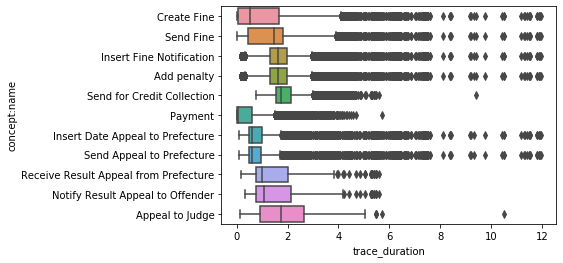

In [53]:
import seaborn as sns

sns.boxplot(
    data=df,
    x='trace_duration',
    y='concept:name'
)

In [49]:
trace_duration = df_no_appeal.groupby('case:concept:name')['time:timestamp'].max() - df_no_appeal.groupby('case:concept:name')['time:timestamp'].min()

df_no_appeal['trace_duration'] = df_no_appeal['case:concept:name'].map(trace_duration) / np.timedelta64(1, 'D')

df_no_appeal.head()

<ipython-input-49-d8536b9b30ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_appeal['trace_duration'] = df_no_appeal['case:concept:name'].map(trace_duration) / np.timedelta64(1, 'D')


,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,has_appeal,trace_duration
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+02:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,False,134.041667
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+01:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN,False,134.041667
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+02:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,False,971.000000
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+01:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN,False,971.000000
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+01:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,False,971.000000


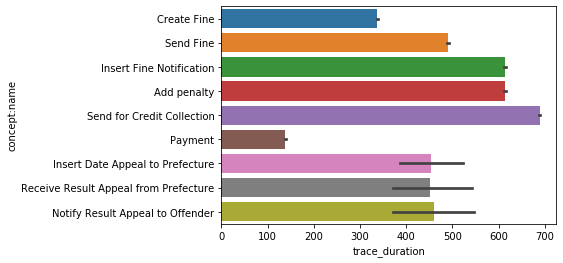

In [50]:
import seaborn as sns

sns.barplot(
    data=df_no_appeal,
    x='trace_duration',
    y='concept:name'
)

# Additional investigations

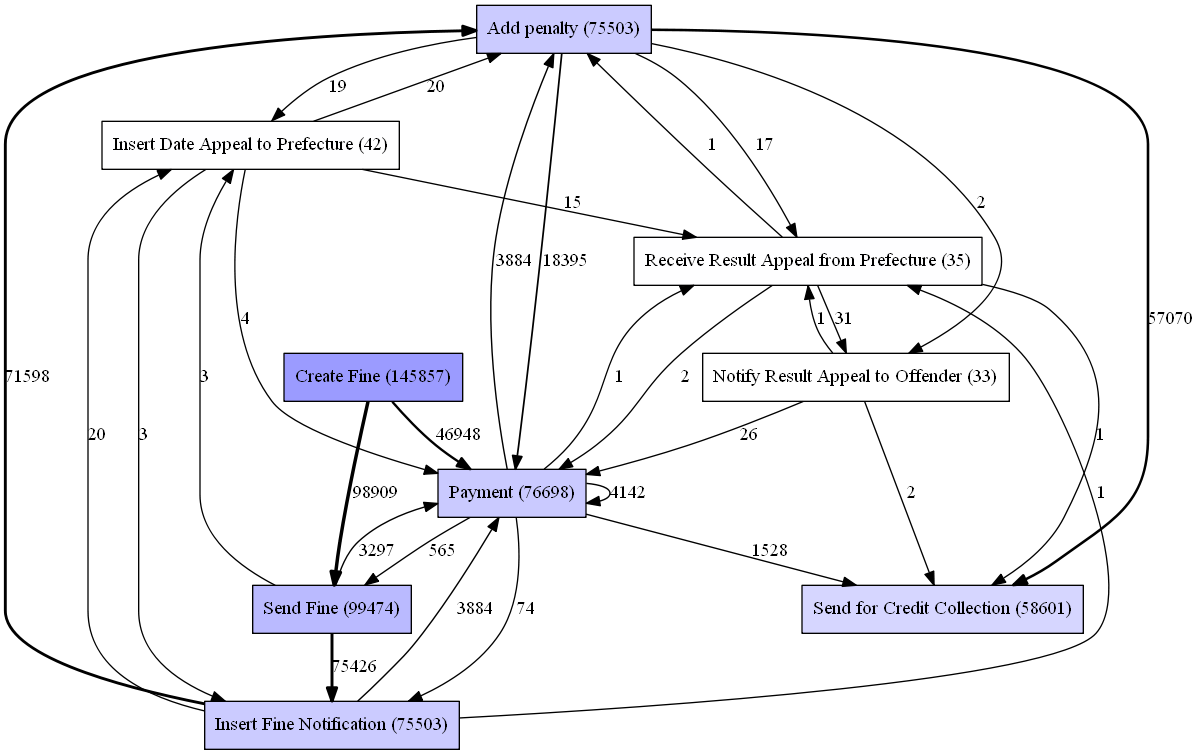

In [27]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(log_no_appeal)

from pm4py.visualization.dfg import visualizer as dfg_visualization
gviz = dfg_visualization.apply(dfg, log=log_no_appeal, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)